* **기후정보학및실습** HW6
조선아(2173112)
* 분석 기간: 1982-2022 (41년)
* 95% 신뢰수준 설정

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 불러오기
!pip install cartopy

import xarray as xr
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

from scipy import stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.4 MB/s eta 0:00:00


Define your ENSO index (e.g., NINO3.4 index) or alternatively take one from the web.
* 강의에서 소개한 예제 사용 (NINO3.4 구역의 SST를 활용한 정규화된 지수 생성)
* (+0.5/-0.5를 기준으로 각각 엘니뇨/라니냐 시기로 정의)

In [3]:
# OISSTv2 데이터 불러오기
fsst = f'https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.mnmean.nc'
urllib.request.urlretrieve(fsst, 'fsst.nc')
sst = xr.open_dataset('fsst.nc')['sst'].sel(time=slice('1982', '2022'))

In [4]:
# climatology 계산 후 제거하여 anomaly 생성
sst_clim = sst.groupby('time.month').mean('time')
sst_anom = sst.groupby('time.month') - sst_clim
# DJF 데이터 선택
sst_anom_DJF = sst_anom.sel(time=((sst_anom['time.month'] == 12) |(sst_anom['time.month'] == 1) | (sst_anom['time.month'] == 2)))

# NINO.4 구역 설정
lon_min, lon_max = 190, 240
lat_min, lat_max = -5, 5

# NINO.4 구역의 SST를 평균하여 정규화
nino34 = sst_anom.where((sst_anom.lon >= lon_min) & (sst_anom.lon <= lon_max) &
                           (sst_anom.lat >= lat_min) & (sst_anom.lat <= lat_max)).mean(dim=['lat', 'lon'], skipna=True)
nino34_norm = (nino34 - nino34.mean()) / nino34.std()

# DJF 데이터 선택
nino34_DJF = nino34_norm.sel(time=((nino34_norm['time.month'] == 12) |(nino34_norm['time.month'] == 1) | (nino34_norm['time.month'] == 2)))

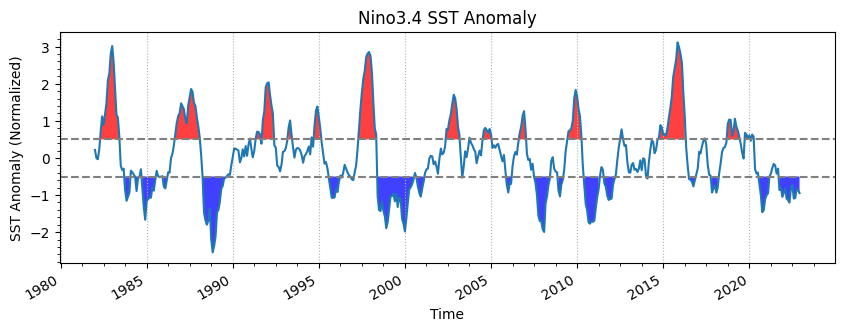

In [5]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()

nino34_norm.plot(ax=ax, label='Nino3.4 SST Anomaly')

ax.axhline(y=0.5, color='gray', linestyle='--')
ax.axhline(y=-0.5, color='gray', linestyle='--')

ax.fill_between(nino34_norm.time.values, 0.5, nino34_norm, where=nino34_norm > 0.5, facecolor='red', alpha=0.75)
ax.fill_between(nino34_norm.time.values, -0.5, nino34_norm, where=nino34_norm < -0.5, facecolor='blue', alpha=0.75)
ax.minorticks_on()
ax.grid(which='major', axis='x', linestyle=':')

ax.set_title('Nino3.4 SST Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('SST Anomaly (Normalized)')

plt.show()

We would like to investigate how DJF mean precipitation changes associated with the ENSO. Find DJF precipitation anomalies associated with the ENSO by either applying 1) composite analysis or 2) correlation analysis. Perform a test to show that the anomalies are statistically significant. Describe your results.


In [6]:
# GPCP precipitation 데이터 불러오기
fprecip = f'https://downloads.psl.noaa.gov/Datasets/gpcp/precip.mon.mean.nc'
urllib.request.urlretrieve(fprecip, 'fprecip.nc')
precip = xr.open_dataset('fprecip.nc')['precip'].sel(time=slice('1982', '2022'))

# climatology 계산 후 제거하여 anomaly 생성
precip_clim = precip.groupby('time.month').mean('time')
precip_anom = precip.groupby('time.month') - precip_clim

# DJF 데이터 선택
precip_anom_DJF = precip_anom.sel(time=((precip_anom['time.month'] == 12) |(precip_anom['time.month'] == 1) | (precip_anom['time.month'] == 2)))

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


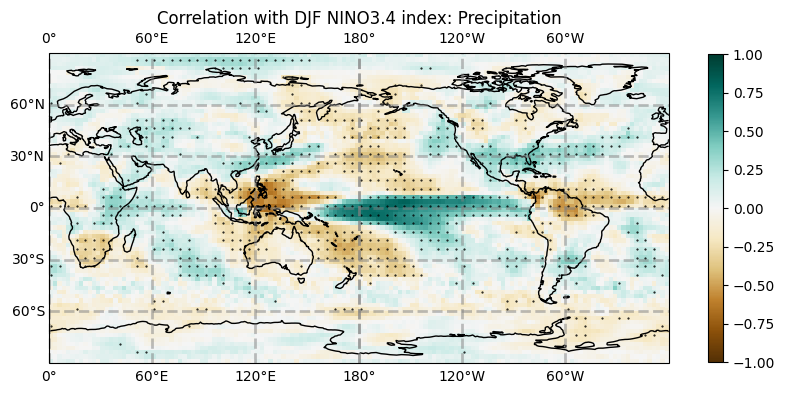

In [7]:
# correlation analysis 수행 후 그림을 그려주는 함수 생성
def corr_plot(data, cmaps, title):
    nino34_corr = xr.corr(nino34_DJF, data, dim='time') # NINO3.4 인덱스와 correlation 계산

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    # 지정한 colormap으로 correlation plot
    nino34_corr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmaps, add_colorbar=True, cbar_kwargs={'shrink':0.8},vmin=-1,vmax=1)

    # 유의성 검정 과정에서, 가독성을 위해 모든 점에 대해 검정하는 대신 두 칸씩 띄워서 검정하기 위함
    skip = 2
    lon_indices = np.arange(0, len(nino34_corr.lon), skip)
    lat_indices = np.arange(0, len(nino34_corr.lat), skip)

    # lon, lat 인덱스를 순회하며 NaN이 아닌 지점에서 correlation이 95% 신뢰수준에 대해 유의한지 검정
    for lon_idx in lon_indices:
        for lat_idx in lat_indices:
            lon = nino34_corr.lon[lon_idx].values
            lat = nino34_corr.lat[lat_idx].values
            if np.isnan(nino34_corr.sel(lon=lon, lat=lat).values):
                continue
            corr_coef, p_value = stats.pearsonr(nino34_DJF, data.sel(lon=lon, lat=lat))
            if (p_value < 0.05): # 유의수준 설정
                ax.plot(lon, lat, marker='o', color='k', markersize=0.5, transform=ccrs.PlateCarree())
                # 통계적으로 유의한 지점 위에 검은색 마커로 점을 기록함

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    ax.coastlines()
    ax.set_title('Correlation with DJF NINO3.4 index: '+title)

    plt.show()

corr_plot(precip_anom_DJF, 'BrBG', 'Precipitation')

**DJF Precipitation**
- 95% 신뢰수준에서 NINO3.4 index와 통계적으로 유의한 상관관계를 보이는 지역은 다음과 같다.
    * 양의 상관관계(엘니뇨 시기에 강수량 증가): 북아메리카의 서안/남안, 남아메리카 남반구 중위도, **적도태평양**, 한반도 남해 인근, 서아시아, 동아프리카, 북극해 일부 등
    * 음의 상관관계(엘니뇨 시기에 강수량 감소): **동남아시아**, 오세아니아 대륙의 동안, 남아프리카, 남아메리카의 적도 부근, 중위도 태평양 등
- Correlation analysis 결과와 별개로, 아래와 같은 엘니뇨와 라니냐 상태에 대한 Composite analysis 결과에서는 두 강수 아노말리의 절댓값과 패턴이 서로 대칭적이지 않다.

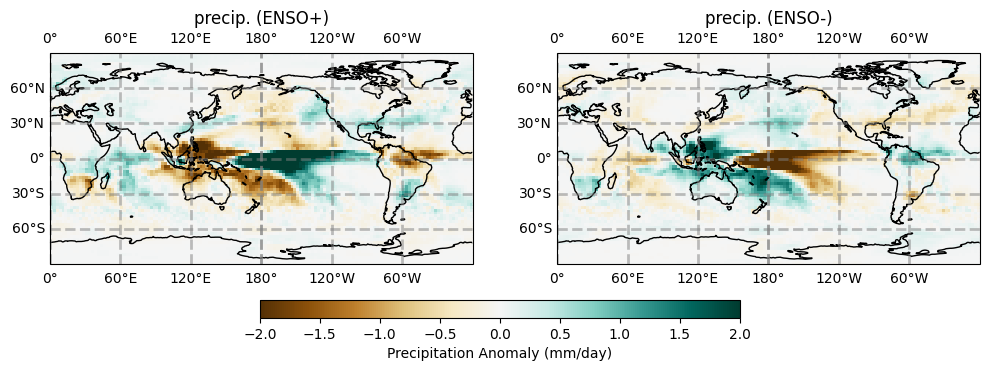

In [8]:
# composite (supplementary)

# 엘니뇨/라니냐 시기를 정의에 따라 구분하여 평균을 구함
el_nino_precip = precip_anom_DJF.sel(time=nino34_DJF > 0.5).mean('time')
la_nina_precip = precip_anom_DJF.sel(time=nino34_DJF < -0.5).mean('time')

fig = plt.figure(figsize=(12, 6))

# El Niño composite
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
im1 = el_nino_precip.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax1.set_title('precip. (ENSO+)')

# La Niña composite
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
im2 = la_nina_precip.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax2.set_title('precip. (ENSO-)')

cbar_ax = fig.add_axes([0.3, 0.23, 0.4, 0.03])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Precipitation Anomaly (mm/day)')

plt.show()

Repeat your analysis for DJF geopotential at 500 hPa.
Describe your results.

In [9]:
# NCEP Reanalysis hgt 데이터 불러오기
fhgt = f'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/pressure/hgt.mon.mean.nc'
urllib.request.urlretrieve(fhgt, 'fhgt.nc')
hgt = xr.open_dataset('fhgt.nc')['hgt'].sel(level=500, time=slice('1982', '2022')) # level=500 선택

# climatology 계산 후 제거하여 anomaly 생성
hgt_clim = hgt.groupby('time.month').mean('time')
hgt_anom = hgt.groupby('time.month') - hgt_clim
# DJF 데이터 선택
hgt_anom_DJF = hgt_anom.sel(time=((hgt_anom['time.month'] == 12) |(hgt_anom['time.month'] == 1) | (hgt_anom['time.month'] == 2)))

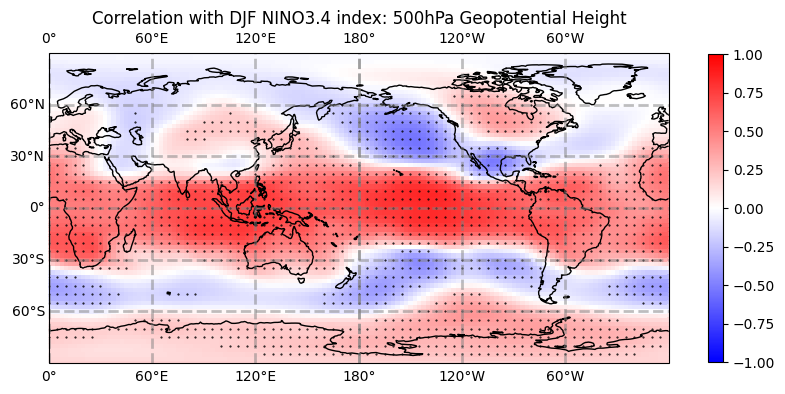

In [10]:
# 앞서 생성한 corr_plot 함수 사용
corr_plot(hgt_anom_DJF, 'bwr', '500hPa Geopotential Height')

**DJF 500hPa Geopotential Height**
* 저위도에서는 95% 신뢰수준에서 NINO3.4 index와 통계적으로 유의한 양의 상관관계를 보인다. (엘니뇨 시기에 해당 지역의 Z500 증가)
* 중위도에서 유의한 상관관계를 지닌 패턴은 다음과 같다.
    - 북반구: 북태평양-미국-중위도 대서양(약한 상관성)에 걸쳐 NINO3.4 index와 음의 상관관계를 보인다. (엘니뇨 시기에 해당 지역의 Z500 감소)
    - 남반구: 특히 태평양에서, 적도를 중심으로 zonally symmetric한 상관관계 패턴을 보인다.
    - 북반구와 남반구 각각에서 PNA-like/PSA-like pattern을 보인다는 특징이 있다.
* Correlation analysis 결과와 별개로, 아래와 같은 엘니뇨와 라니냐 상태에 대한 Composite analysis 결과에서는 두 Z500 패턴이 서로 대칭적이지 않다. 엘니뇨 시기의 아노말리 절댓값이 더 크고, 절댓값이 가장 큰 위치의 경도가 다르다.

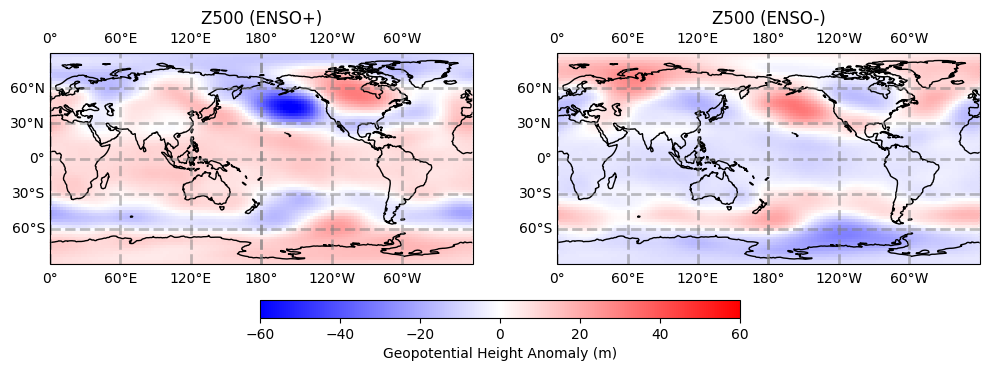

In [11]:
# composite (supplementary)

# 엘니뇨/라니냐 시기를 정의에 따라 구분하여 평균을 구함

el_nino_hgt = hgt_anom_DJF.sel(time=nino34_DJF > 0.5).mean('time')
la_nina_hgt = hgt_anom_DJF.sel(time=nino34_DJF < -0.5).mean('time')
fig = plt.figure(figsize=(12, 6))

# El Niño composite
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
im1 = el_nino_hgt.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='bwr', add_colorbar=False, vmin=-60, vmax=60)
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax1.set_title('Z500 (ENSO+)')

# La Niña composite
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
im2 = la_nina_hgt.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='bwr', add_colorbar=False, vmin=-60, vmax=60)
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax2.set_title('Z500 (ENSO-)')

cbar_ax = fig.add_axes([0.3, 0.23, 0.4, 0.03])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Geopotential Height Anomaly (m)')

plt.show()